# Analyze Covid-19 literature

Pubmed is a free search engine accessing primarily the MEDLINE database of references and abstracts on life sciences and biomedical topics.  A simple search for 'covid-19' on pubmed resulted in 156,871 citations, an impossible number of papers for anyone to seep through.  I set out to see whether I can get some kind of understanding of the trend literature using natural language processing.  The text file containing one year worth of abstracts were saved from https://pubmed.ncbi.nlm.nih.gov/?term=covid-19&filter=simsearch1.fha&filter=datesearch.y_1

### <b>1.  Read data

In [1]:
# Import libraies
import nltk, pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime as dt, re, random, pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
%matplotlib inline

# get stop words
stopwords = set(stopwords.words('english'))

### <b>1 Read in data </b>

In the txt file, each record has 7 paragraphs: 1. Journal info, 2. Title, 3. Author names, 4. Author info, 5. abstract, 6. copyright, 7. DOI, PMCID, PMID.  record for each.  I am only interested in the absract and PMID.

In [183]:
with open('abstract-covid-19.txt') as file:
    data = file.read()
    records = [x.split('\n\n') for x in data.split('\n\n\n')]
    print(len(records[0]))


7


In [184]:
records[10][4]

'OBJECTIVE: To collate the evidence on the accuracy parameters of all available \ndiagnostic methods for detecting SARS-CoV-2.\nMETHODS: A systematic review with meta-analysis was performed. Searches were \nconducted in Pubmed and Scopus (April 2020). Studies reporting data on \nsensitivity or specificity of diagnostic tests for COVID-19 using any human \nbiological sample were included.\nRESULTS: Sixteen studies were evaluated. Meta-analysis showed that computed \ntomography has high sensitivity (91.9% [89.8%-93.7%]), but low specificity \n(25.1% [21.0%-29.5%]). The combination of IgM and IgG antibodies demonstrated \npromising results for both parameters (84.5% [82.2%-86.6%]; 91.6% [86.0%-95.4%], \nrespectively). For RT-PCR tests, rectal stools/swab, urine, and plasma were less \nsensitive while sputum (97.2% [90.3%-99.7%]) presented higher sensitivity for \ndetecting the virus.\nCONCLUSIONS: RT-PCR remains the gold standard for the diagnosis of COVID-19 in \nsputum samples. However,

In [185]:
records[0][6].split('\n')[2][6:14]

'32761898'

In [186]:
cleaned = []
for rec in records:
    try:
        abst= rec[4]
        pmid = rec[6].split('\n')[2][6:14]
        cleaned.append([pmid, abst])
    except:
        pass

In [187]:
print(len(cleaned))

5368


In [188]:
df = pd.DataFrame(cleaned, columns=['pmid','abstract'])
df.head(3)

,pmid,abstract
0,32761898,To provide a comprehensive and systematic anal...
1,33008761,OBJECTIVE: To review the available literature ...
2,32330303,"Coronavirus disease (COVID-19), caused by a no..."


### <b>2.1 Clean data 

In [189]:
# inspect the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5368 entries, 0 to 5367
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmid      5368 non-null   object
 1   abstract  5368 non-null   object
dtypes: object(2)
memory usage: 84.0+ KB


In [190]:
# remove potential duplicates. 

df = df.drop_duplicates()
print(df.shape)

(5365, 2)


In [191]:
# check whether pmid are correctly extracted

df.pmid.str.match(r'[^0-9]').value_counts()

False    4430
True      935
Name: pmid, dtype: int64

In [192]:
# remove records with bad pmid

df = df[df.pmid.str.match(r'[0-9]')]

In [193]:
# check for potential short, unsable abstract. based on visual inspection, 50 word threshood is choosen.  

[x for x in df.abstract if len(x.split()) < 40]

['Comment in\n    J Med Virol. 2021 Jan;93(1):137-138.\n    J Med Virol. 2021 Feb;93(2):639-640.',
 'Comment in\n    Respirology. 2021 Feb;26(2):143-144.\n    BMJ. 2020 Dec 23;371:m4919.\n    Trials. 2021 Mar 29;22(1):234.',
 'Comment in\n    Radiology. 2021 Jan 5;:204471.',
 'Comment in\n    JAMA Pediatr. 2021 Jan 1;175(1):16-18.',
 'Update of\n    medRxiv. 2020 Oct 05;:',
 'Comment in\n    J Urol. 2021 Jul;206(1):139-140.',
 'Erratum in\n    Virol J. 2021 Feb 18;18(1):41.',
 'Update of\n    medRxiv. 2020 Sep 03;:',
 'Update of\n    medRxiv. 2020 May 25;:',
 'Comment in\n    doi: 10.1001/jamainternmed.2021.0366.\n    doi: 10.1001/jama.2020.18598.\n    doi: 10.1001/jama.2020.18796.\n    doi: 10.1001/jama.2021.3341.\n    doi: 10.1001/jama.2020.25457.\n    doi: 10.1001/jama.2021.3368.\n    doi: 10.1001/jama.2021.6042.',
 'Erratum in\n    Virol J. 2021 Apr 20;18(1):82.',
 'Update of\n    medRxiv. 2021 Jan 20;:',
 'Comment in\n    JAMA Intern Med. 2021 May 1;181(5):679.',
 'Comment in\n   

Looks like for those abstracts starting with 'Comment in', 'Comment on', Erratum in', 'Author information:', they are not true abstracts.   

In [194]:
# remove abstracts starting with 'Comment in', 'Comment on', 'Erratum in', 'Author information:', Update of

df = df[np.core.chararray.find(df.abstract.values.astype(str), 'Comment in') < 0]
df = df[np.core.chararray.find(df.abstract.values.astype(str), 'Comment on') < 0]
df = df[np.core.chararray.find(df.abstract.values.astype(str), 'Erratum in') < 0]
df = df[np.core.chararray.find(df.abstract.values.astype(str), 'Author information:') < 0]
df = df[np.core.chararray.find(df.abstract.values.astype(str), 'Update of') < 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4009 entries, 0 to 5367
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmid      4009 non-null   object
 1   abstract  4009 non-null   object
dtypes: object(2)
memory usage: 94.0+ KB


In [195]:
[x for x in df.abstract if len(x.split()) < 40]

['Parent scientists lead a journey to bring surveillance\xa0severe acute respiratory \nsyndrome coronavirus 2\xa0(SARS-CoV-2) testing to public schools across the state \nof Massachusetts and beyond.',
 'Wnt5a/Wnt11 can be used as potential ARDS biomarkers for SARS-CoV-2 patients \nhttps://bit.ly/3lxEGRA',
 'Over 100 attempts are being made to develop a vaccine for use in the epidemic of \nCOVID-19. Many different technologies are being used in an effort to prevent the \ninfection or at least the disease.',
 'Developers of severe acute respiratory syndrome coronavirus 2 vaccines should \nconsider some of the lessons from a "new" vaccine introduced in 1921, namely \nbacille Calmette-Guérin.',
 'Having the right data is critical in managing a crisis. More so, at the time of \na pandemic. Rather than relying heavily on absolute numbers, we discuss \nalternatives that could improve testing numbers in India.',
 'We report a case of a 50-year-old male with a history of HIV and kidney \ntrans

In [108]:
# spot check the data

df.iloc[3,1]

'Reverse transcription-quantitative PCR (RT-qPCR)-based tests are widely used to \ndiagnose coronavirus disease 2019 (COVID-19). As a result that these tests \ncannot be done in local clinics where RT-qPCR testing capability is lacking, \nrapid antigen tests (RATs) for COVID-19 based on lateral flow immunoassays are \nused for rapid diagnosis. However, their sensitivity compared with each other \nand with RT-qPCR and infectious virus isolation has not been examined. Here, we \ncompared the sensitivity among four RATs by using severe acute respiratory \nsyndrome coronavirus 2 (SARS-CoV-2) isolates and several types of COVID-19 \npatient specimens and compared their sensitivity with that of RT-qPCR and \ninfectious virus isolation. Although the RATs read the samples containing large \namounts of virus as positive, even the most sensitive RAT read the samples \ncontaining small amounts of virus as negative. Moreover, all RATs tested failed \nto detect viral antigens in several specimens f

### 2.2.  Removing non_alphabetic characters

In [196]:
# remove any non-alphabetic characters and one word words.  Including two letter words in the initial analysis because words like US, UK, Cl, CT have meanings that might be useful.

dfw = df.copy()
dfw['abstract'] = df.abstract.str.replace(r'[^A-Za-z ]+', ' ')

# change to lower case and remove stopwords
dfw['abstract'] = dfw.abstract.apply(lambda x: ' '.join([w.lower().strip() for w in x.split() if (w.lower() not in stopwords) & (len(w)>1)]))
dfw.head(2)

,pmid,abstract
0,32761898,provide comprehensive systematic analysis demo...
1,33008761,objective review available literature concerni...


### 2.3. Lemmatization

In [197]:
# perform lemmtization on abstracts

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

dfw['lem_abs'] = dfw.abstract.apply(lemmatize_text)
dfw.head(3)


,pmid,abstract,lem_abs
0,32761898,provide comprehensive systematic analysis demo...,"[provide, comprehensive, systematic, analysis,..."
1,33008761,objective review available literature concerni...,"[objective, review, available, literature, con..."
2,32330303,coronavirus disease covid caused novel betacor...,"[coronavirus, disease, covid, caused, novel, b..."


### 2.4. Determine average length of abstracts

In [198]:
dfw['wc'] = dfw.lem_abs.apply(lambda x: len(x))
dfw.head(3)

,pmid,abstract,lem_abs,wc
0,32761898,provide comprehensive systematic analysis demo...,"[provide, comprehensive, systematic, analysis,...",119
1,33008761,objective review available literature concerni...,"[objective, review, available, literature, con...",184
2,32330303,coronavirus disease covid caused novel betacor...,"[coronavirus, disease, covid, caused, novel, b...",104


In [199]:
print(f'Average words in cleaned records is {int(dfw.wc.mean())} words.')

Average words in cleaned records is 128 words.


### <b>3.  Top words analysis

In [200]:
# spot check unique two-letter words in the list

print(set([x for x in allwords if len(x) < 3][:500]))

set()


In [201]:
# most of the two letter words won't be useful, will remove

dfw['abstract'] = dfw.abstract.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
dfw['lem_abs'] = dfw.lem_abs.apply(lambda x: [w for w in x if len(w)>2])
dfw['wc'] = dfw.lem_abs.apply(lambda x: len(x))
dfw.head(3)

,pmid,abstract,lem_abs,wc
0,32761898,provide comprehensive systematic analysis demo...,"[provide, comprehensive, systematic, analysis,...",106
1,33008761,objective review available literature concerni...,"[objective, review, available, literature, con...",171
2,32330303,coronavirus disease covid caused novel betacor...,"[coronavirus, disease, covid, caused, novel, b...",104


In [202]:
# generate wordbag from all the abstracts

allwords = dfw['lem_abs'].tolist()

# flatten the list
allwords = [item for sublist in allwords for item in sublist]
print(f'There are {len(allwords)} total words in all abstracts')
print(f'Average words for the abstracts is {int(dfw.wc.mean())} words.')

There are 504656 total words in all abstracts
Average words for the abstracts is 125 words.


In [203]:
# word frequency counts

word_freq = nltk.FreqDist(allwords)
dff = pd.DataFrame(list(word_freq.items()), columns = ['word','freq']) 
dff = dff.sort_values(by='freq', ascending=False).reset_index()
dff.head(3)

,index,word,freq
0,185,cov,10824
1,184,sars,10688
2,14,covid,10393


In [204]:
dff.describe()

,index,freq
count,17735.000000,17735.000000
mean,8867.000000,28.455371
std,5119.797848,192.513692
min,0.000000,1.000000
25%,4433.500000,1.000000
50%,8867.000000,3.000000
75%,13300.500000,9.000000
max,17734.000000,10824.000000


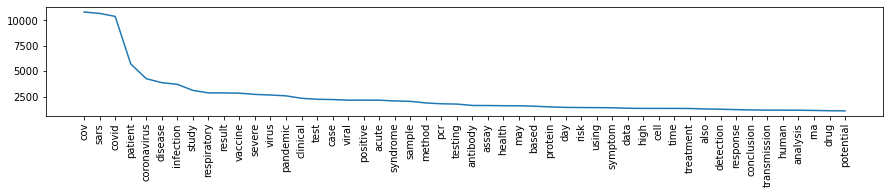

In [205]:
# plot frequency of the top 50 words that appeared more than 11 times

plt.figure(figsize=(15, 2)) 
plt.plot(dff[dff.freq > 11].word[:50], dff[dff.freq > 11].freq[:50])
plt.xticks(rotation=90);

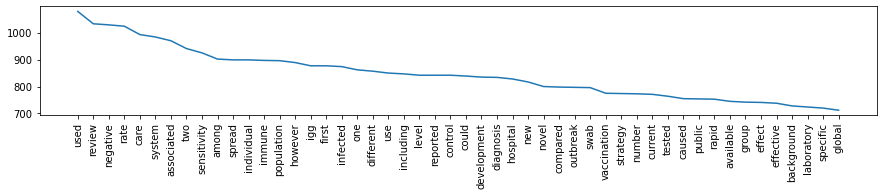

In [206]:
# plot frequency of the top 50-100 words that appeared more than 11 times

plt.figure(figsize=(15, 2)) 
plt.plot(dff[dff.freq > 11].word[50:100], dff[dff.freq > 11].freq[50:100])
plt.xticks(rotation=90);

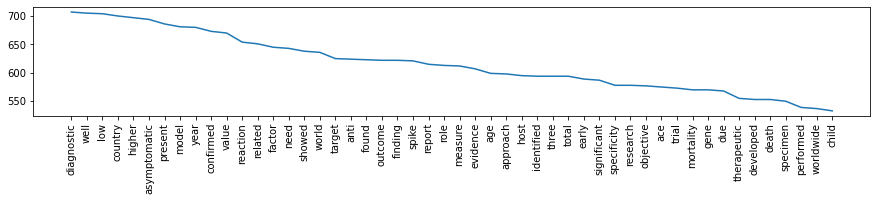

In [207]:
# plot frequency of the top 100 - 150 words that appeared more than 11 times

plt.figure(figsize=(15, 2)) 
plt.plot(dff[dff.freq > 11].word[100:150], dff[dff.freq > 11].freq[100:150])
plt.xticks(rotation=90);

Text(0.5, 1.0, 'Top 100-200 words')

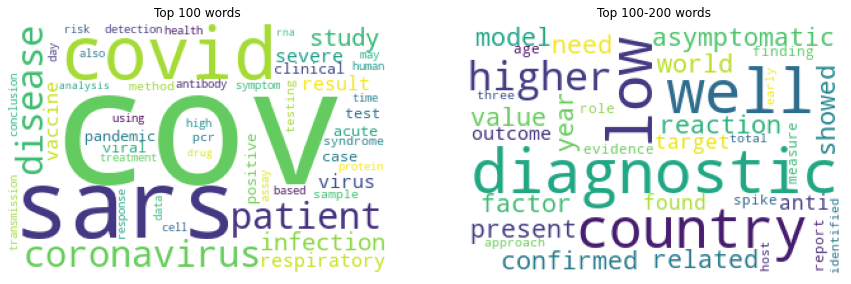

In [208]:
# generate word cloud

word100 = ' '.join(dff[dff.freq > 11].word[:100])
word200 = ' '.join(dff[dff.freq > 11].word[100:200])
wc100 = WordCloud(width = 300, height = 200,background_color ='white', stopwords = stopwords, min_font_size = 8).generate(word100)
wc200 = WordCloud(width = 300, height = 200,background_color ='white', stopwords = stopwords, min_font_size = 8).generate(word200)

plt.figure(figsize = (15, 5), facecolor = None)
ax1 = plt.subplot(1,2,1)
ax1.imshow(wc100)
ax1.axis("off")
ax1.set_title("Top 100 words")

ax2 = plt.subplot(1,2,2)
ax2.imshow(wc200)
ax2.axis("off")
ax2.set_title("Top 100-200 words")

In [209]:
print(f'About {dff[dff.freq  == 1].shape[0]} words that only appeared once.')
print(dff[dff.freq  == 1].word[:50].tolist())

About 6321 words that only appeared once.
['nemo', 'freshwater', 'sara', 'swimming', 'pretransfusion', 'antagonizes', 'nascent', 'pharmaceutic', 'instigate', 'spms', 'prosa', 'agribusiness', 'vomit', 'ramachandran', 'deglycosylation', 'polyubiquitination', 'microvesicles', 'iic', 'cstj', 'assault', 'nutraceutical', 'sidewalk', 'sedimentable', 'casirimab', 'dish', 'cpla', 'apparel', 'clothes', 'passion', 'honeybee', 'honey', 'broker', 'leukotrienes', 'intraluminal', 'injuring', 'jelly', 'petri', 'turbulence', 'innately', 'coalesce', 'untimely', 'exchanger', 'beeswax', 'posttransfusion', 'ikk', 'nitrosation', 'immersion', 'resolving', 'mrd', 'surfing']


### <b>5. Topic Modeling using Latent Dirichlet Allocation 

In [210]:
# create vocabulary of all the words, include words that appear in less than 80% of the document and appear in at least 2 documents.  https://stackabuse.com/python-for-nlp-topic-modeling

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(dfw['abstract'].values.astype('U'))
doc_term_matrix

<4009x11055 sparse matrix of type '<class 'numpy.int64'>'
	with 333120 stored elements in Compressed Sparse Row format>

In [211]:
# creating LDA model for 8 topics

LDA_8t = LatentDirichletAllocation(n_components=8, random_state=42)
LDA_8t.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=8, random_state=42)

In [212]:
# find words with the highest probability for the first topic

first_topic = LDA_8t.components_[0]
top_topic_words = first_topic.argsort()[-10:]
top_words  = [count_vect.get_feature_names()[w] for w in top_topic_words.argsort()[-10:]]
print(f'Top words for topic #0 of 8:')
print(top_words)

Top words for topic #0 of 8:
['abc', 'abdomen', 'aat', 'aberrant', 'abdominal', 'abbreviated', 'abating', 'abbott', 'abandon', 'aas']


In [213]:
# save top words with highest probabilities for 8 topics.

top_ls8t = []
for i,topic in enumerate(LDA_8t.components_):
    top_words = sorted([count_vect.get_feature_names()[w] for w in topic.argsort()[-10:]])
    top_ls8t.append(top_words)

In [214]:
# print top word lists

for item in top_ls8t:
    print(item)

['clinical', 'coronavirus', 'cov', 'covid', 'disease', 'pandemic', 'patients', 'review', 'sars', 'vaccines']
['assay', 'cov', 'igg', 'pcr', 'positive', 'results', 'samples', 'sars', 'sensitivity', 'test']
['coronavirus', 'cov', 'covid', 'disease', 'infection', 'patients', 'positive', 'sars', 'severe', 'symptoms']
['cases', 'coronavirus', 'cov', 'covid', 'infection', 'risk', 'sars', 'transmission', 'virus', 'wastewater']
['covid', 'dose', 'health', 'participants', 'results', 'study', 'survey', 'vaccination', 'vaccine', 'vaccines']
['care', 'countries', 'covid', 'health', 'healthcare', 'measures', 'pandemic', 'results', 'social', 'testing']
['cells', 'coronavirus', 'cov', 'covid', 'infection', 'protein', 'respiratory', 'sars', 'viral', 'virus']
['based', 'coronavirus', 'cov', 'covid', 'detection', 'diagnostic', 'rapid', 'rna', 'sars', 'testing']


In [215]:
# creating LDA model for 15 topics

LDA_15t = LatentDirichletAllocation(n_components=15, random_state=42)
LDA_15t.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=15, random_state=42)

In [216]:
#  save top words with highest probabilities for 15 topics.

top_ls15t = []
for i,topic in enumerate(LDA_15t.components_):
    top_words = sorted([count_vect.get_feature_names()[w] for w in topic.argsort()[-10:]])
    top_ls15t.append(top_words)

In [217]:
# print top word lists

for item in top_ls15t:
    print(item)

['clinical', 'coronavirus', 'cov', 'covid', 'development', 'disease', 'pandemic', 'review', 'vaccine', 'vaccines']
['asymptomatic', 'children', 'coronavirus', 'cov', 'infection', 'positive', 'respiratory', 'sars', 'tested', 'women']
['cases', 'clinical', 'coronavirus', 'covid', 'disease', 'patients', 'positive', 'results', 'severe', 'symptoms']
['air', 'cases', 'coronavirus', 'cov', 'covid', 'sars', 'spread', 'transmission', 'virus', 'wastewater']
['cluster', 'clusters', 'data', 'household', 'inactivation', 'index', 'individuals', 'reporting', 'surveillance', 'virus']
['africa', 'challenges', 'covid', 'disease', 'face', 'healthcare', 'mask', 'masks', 'pandemic', 'use']
['acute', 'coronavirus', 'cov', 'covid', 'disease', 'infection', 'respiratory', 'sars', 'severe', 'syndrome']
['based', 'coronavirus', 'cov', 'covid', 'detection', 'diagnostic', 'rapid', 'rna', 'sars', 'testing']
['articles', 'covid', 'included', 'literature', 'pubmed', 'review', 'search', 'studies', 'systematic', 'used'

### <b> 6. Recommending/selecting papers using top words  </b>

In [218]:
# find abstracts contain 90% of the top words for each of the 8 topics

dfs8t = {}
for i,ls in enumerate(top_ls8t):
    dfs8t[i] = dfw[dfw.lem_abs.apply(lambda x: len(list(set(x) & set(top_ls8t[i]))) >= len(top_ls8t[i])*0.9)]
    print(f'There are {dfs8t[i].shape[0]} records contain more than 90% top words in topic {i} of 8')

There are 0 records contain more than 90% top words in topic 0 of 8
There are 0 records contain more than 90% top words in topic 1 of 8
There are 0 records contain more than 90% top words in topic 2 of 8
There are 6 records contain more than 90% top words in topic 3 of 8
There are 0 records contain more than 90% top words in topic 4 of 8
There are 0 records contain more than 90% top words in topic 5 of 8
There are 35 records contain more than 90% top words in topic 6 of 8
There are 33 records contain more than 90% top words in topic 7 of 8


In [219]:
# find abstracts contain 90% of the top 10 words for each of the 15 topics
dfs15t = {}
for i,ls in enumerate(top_ls15t):
    dfs15t[i] = dfw[dfw.lem_abs.apply(lambda x: len(list(set(x) & set(top_ls15t[i]))) >= len(top_ls15t[i])*0.9)]
    print(f'There are {dfs15t[i].shape[0]} records contain more than 90% top words in topic {i} of 15')

There are 21 records contain more than 90% top words in topic 0 of 15
There are 0 records contain more than 90% top words in topic 1 of 15
There are 0 records contain more than 90% top words in topic 2 of 15
There are 3 records contain more than 90% top words in topic 3 of 15
There are 0 records contain more than 90% top words in topic 4 of 15
There are 0 records contain more than 90% top words in topic 5 of 15
There are 1185 records contain more than 90% top words in topic 6 of 15
There are 33 records contain more than 90% top words in topic 7 of 15
There are 0 records contain more than 90% top words in topic 8 of 15
There are 9 records contain more than 90% top words in topic 9 of 15
There are 0 records contain more than 90% top words in topic 10 of 15
There are 0 records contain more than 90% top words in topic 11 of 15
There are 0 records contain more than 90% top words in topic 12 of 15
There are 0 records contain more than 90% top words in topic 13 of 15
There are 0 records conta

In [220]:
# Topic #6 was discussed in the highest number of records in both sets using 8 or 15 topics

print('topic words in topic #6 of 8 topics: ')
print(sorted(top_ls8t[6]))
print('topic words in topic #6 of 15 topics: ')
print(sorted(top_ls15t[6]))

topic words in topic #6 of 8 topics: 
['cells', 'coronavirus', 'cov', 'covid', 'infection', 'protein', 'respiratory', 'sars', 'viral', 'virus']
topic words in topic #6 of 15 topics: 
['acute', 'coronavirus', 'cov', 'covid', 'disease', 'infection', 'respiratory', 'sars', 'severe', 'syndrome']


In [223]:
print(f'Top ten words in topic#6 is {len(list(set(top_ls15t[6]) & set(top_ls8t[6])))/len(set(top_ls8t[6]))*100}% identical in both sets')

Top ten words in topic#6 is 60.0% identical in both sets


In [226]:
print('Top ten papers cover topic #6 of 15 topics: ')
print(dfs15t[6][['pmid', 'abstract']].head(10))

Top ten papers cover topic #6 of 15 topics: 
        pmid                                           abstract
2   32330303  coronavirus disease covid caused novel betacor...
6   33305456  background end december novel coronavirus tent...
7   32889088  coronavirus disease covid caused severe acute ...
10  33244462  novel strain severe acute respiratory syndrome...
11  33189872  objectives knowledge previous study assessed p...
12  33307513  coronavirus disease covid caused severe acute ...
13  32609390  ongoing coronavirus disease covid pandemic one...
14  33308664  accurate rapid diagnostic tests critical achie...
17  32856766  diagnosis covid requires integration clinical ...
20  33390829  coronavirus disease covid caused severe acute ...


<b>Summary</b>

1. In this study, I imported csv fiels from pubmed that contains the dumped data for 2019-2020.  Three types of analysis were performed to get some insight on covid literature.

2. The first attempt was to examine the top words in the whole data set to see what insights one might be able to infer from the data.  I found that one can get a sense of what was discussed based on top words.  But, there is limit to get indepth information based on top words.

3. Next I took the advange of train test and validate data sets that have prelabels for the type of study for the abstract.  I tranied a SVC and predicted the labels for the test and validation data sets.  The labels in the train set has one or more labels.  The model was able to make about 44% correct predictions if one consider as long as the predicted label is one of the words in the set, it is a correct prediction.  A detailed examination of the result shown that this approach was not ddsirable since one only one label was predicted by the model.  To do this properly, the labels should be reexamined and cleaned.  

4. Thirdly, I performed topic modeling using Latent Dirichlet Allocation (LDA) method.  Since the original data sets has eight differnt labels, I first performed the analysis using 8 topics.  Then also tried 15 topics.  Based on the top ten words for the mostly discussed topic, I concluded that 8 topics is sufficient for teasing out the difference in topics.  BAsed on this analysis, it is possible to pick out papers that disccuss certain topics.  